In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

random_state = 1234

os.getcwd()

'd:\\MM\\mefor44.github.io\\notebooks'

In [2]:
path_impr_dir = "D:/DATA/ContentWiseImpressions/data/ContentWiseImpressions/CW10M/impressions-direct-link"
path_impr_nodir = "D:/DATA/ContentWiseImpressions/data/ContentWiseImpressions/CW10M/impressions-non-direct-link"
path_interactions = "D:/DATA/ContentWiseImpressions/data/ContentWiseImpressions/CW10M/interactions"

## Interactions

In [3]:
interactions = pd.read_parquet(path_interactions)
print(f"Interactions df has {interactions.shape[0]:,} rows")
n_dupl = len(interactions) - interactions[["user_id", "item_id"]].drop_duplicates().shape[0]
print(f"Interactions df has {n_dupl:,} duplicated (user, item) rows (possibly the interaction types are different)")
interactions.head()

Interactions df has 10,457,810 rows
Interactions df has 5,929,670 duplicated (user, item) rows (possibly the interaction types are different)


,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating
utc_ts_milliseconds,,,,,,,,,,
1546851602000,7285,116485,434,5,6,3,56402,0,1.00,-1.0
1546852592000,412,116485,434,5,6,3,-1,1,-1.00,-1.0
1546853242000,10811,116485,434,5,6,3,-1,1,-1.00,-1.0
1546853253000,10811,116485,434,5,6,3,-1,0,0.50,-1.0
1546856158000,10811,116485,434,5,6,3,-1,0,0.99,-1.0


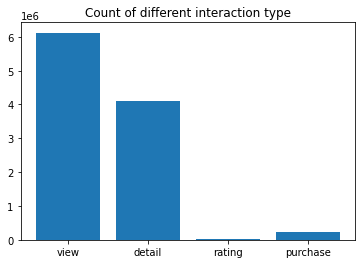

In [4]:
intr_types = {0: "view", 1:"detail", 2:"rating", 3:"purchase"}

intr_types_count = interactions.groupby("interaction_type")["interaction_type"].count()
plt.bar([intr_types[k] for k in intr_types_count.index], intr_types_count.values)
plt.title("Count of different interaction type")
plt.show()

In [5]:
interactions.user_id.nunique(), interactions.user_id.max()

(42153, 42152)

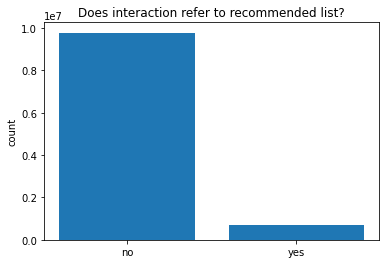

In [6]:
has_rec_list = interactions.recommendation_id.apply(lambda x: 1 if x != -1 else -1).value_counts()
plt.bar(["yes" if i==1 else "no" for i in has_rec_list.index], has_rec_list.values)
plt.title("Does interaction refer to recommended list?")
plt.ylabel("count")
plt.show()


In [7]:
interactions["timestamp"] = pd.to_datetime(interactions.index, unit='ms')
interactions["date"] = interactions["timestamp"].dt.date
intr_daily = interactions.groupby("date")["date"].count()

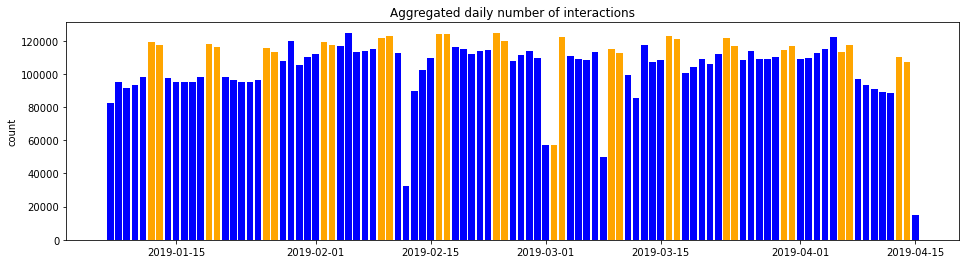

In [8]:
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
days = [dt.datetime.strptime(str(d), '%Y-%m-%d').weekday() for d in intr_daily.index]
days = [day_name[i] for i in days]
colors = ["orange" if i=="Sunday" or i=="Saturday" else "blue" for i in days]


plt.figure(figsize=(16,4))
plt.bar(intr_daily.index, intr_daily.values, color=colors)
plt.ylabel("count")
plt.title("Aggregated daily number of interactions")
plt.show()

In [10]:
clicks_per_user = interactions.groupby("user_id")["user_id"].count()
print(f"Avg number of clicks per user = {clicks_per_user.mean()}")

Avg number of clicks per user = 248.09171351979694


In [11]:
items = interactions.item_id.unique()
len(items)

145074

## Impressions
### Direct

In [12]:
impr_dir = pd.read_parquet(path_impr_dir)
print(f"Direct impressions df has {impr_dir.shape[0]:,} rows")
impr_dir.head()

Direct impressions df has 307,453 rows


,row_position,recommendation_list_length,recommended_series_list
recommendation_id,,,
0,0,10,"[20128, 6674, 4625, 19462, 19041, 23229, 5914,..."
1,0,10,"[7906, 1240, 1712, 8348, 3227, 7607, 24175, 15..."
2,0,10,"[13673, 15810, 16821, 3826, 26860, 22223, 1847..."
3,1,10,"[13673, 1272, 2293, 23996, 15810, 16821, 13737..."
4,0,6,"[21885, 22288, 7493, 17042, 18483, 9330]"


### Non-direct

In [13]:
impr_nodir = pd.read_parquet(path_impr_nodir)
print(f"Non-direct impressions df has {impr_nodir.shape[0]:,} rows")
impr_nodir.head()
# del impr_nodir

Non-direct impressions df has 23,342,617 rows


,row_position,recommendation_list_length,recommended_series_list
user_id,,,
0,1,10,"[21079, 20128, 6674, 28598, 19462, 19041, 7677..."
0,0,5,"[7411, 27339, 28669, 9948, 14988]"
0,2,10,"[23099, 28082, 27641, 9701, 21833, 5654, 23393..."
0,0,10,"[5303, 27643, 19462, 26887, 15810, 3826, 7411,..."
0,1,10,"[5303, 21079, 20128, 6674, 28598, 4625, 19462,..."


In [14]:
impr_nodir.index

Int64Index([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            ...
            8964, 8964, 8964, 8964, 8964, 8964, 8964, 8964, 8964, 8964],
           dtype='int64', name='user_id', length=23342617)

## Preprocess and split
Sample 1 000 000 clicks uniformly to make the dataset smaller. Leave only interactions of type = "view" or "detail". Leave just one interaction for each (user,item) pair. 

In [23]:
print(f"Before filtering, n rows = {len(interactions)}")
interactions = interactions[(interactions["interaction_type"] == 0) | (interactions["interaction_type"] == 1)]
print(f"After filtering, n rows = {len(interactions)}")

print("Removing duplicates...")
print(f"Before removing duplicates, n rows = {len(interactions)}")
interactions = interactions.groupby(["user_id", "item_id"]).agg(recommendation_id=("recommendation_id", "max"),
                                                                timestamp=("timestamp", "max")
                                                                ).reset_index()
print(f"After removing duplicates, n rows = {len(interactions)}")

Before filtering, n rows = 10457810
After filtering, n rows = 10227635
Removing duplicates...
Before removing duplicates, n rows = 10227635
After removing duplicates, n rows = 4525775


In [39]:
n = 1_000_000
sampled_interactions = interactions.sample(n=n, random_state=random_state)
clicks_per_user = sampled_interactions.groupby("user_id")["user_id"].count()
print(f"Number of users = {len(clicks_per_user):,}")
print(f"Avg number of clicks per user = {clicks_per_user.mean()}")

Number of users = 39,578
Avg number of clicks per user = 25.266562231542775


### Combine with imppressions

In [106]:
impr_dir.head()

,row_position,recommendation_list_length,recommended_series_list
recommendation_id,,,
0,0,10,"[20128, 6674, 4625, 19462, 19041, 23229, 5914,..."
1,0,10,"[7906, 1240, 1712, 8348, 3227, 7607, 24175, 15..."
2,0,10,"[13673, 15810, 16821, 3826, 26860, 22223, 1847..."
3,1,10,"[13673, 1272, 2293, 23996, 15810, 16821, 13737..."
4,0,6,"[21885, 22288, 7493, 17042, 18483, 9330]"


In [54]:
impressions = impr_dir[["recommended_series_list"]].explode("recommended_series_list")
impressions = impressions.rename(columns={"recommended_series_list":"item_id"})
impressions = impressions.merge(sampled_interactions[["user_id", "recommendation_id", "timestamp"]], on="recommendation_id", how="inner")
impressions = impressions.drop(["recommendation_id"], axis=1)
impressions["output"] = 0
sampled_interactions["output"] = 1
print(f"Number of zeros (initial) = {len(impressions):,}")
print(f"Number of ones = {len(sampled_interactions):,}")
data = pd.concat([sampled_interactions, impressions], axis=0)
data = data.groupby(["user_id", "item_id"]).agg(output=("output", "max"), timestamp=("timestamp", "max"))
print(f"Number of zeros afer grouping = {data[data.output==0].shape[0]:,}")
print(f"Total number of observations = {len(data)}")

Number of zeros (initial) = 1,124,225
Number of ones = 1,000,000
Number of zeros afer grouping = 639,031
Total number of observations = 1639031


In [52]:
data

,user_id,item_id,recommendation_id,timestamp,date,output
4390393,40845,138863,-1.0,2019-02-20 11:50:33,2019-02-20,1
1711601,15944,20125,-1.0,2019-01-19 22:22:56,2019-01-19,1
4014208,37411,107641,-1.0,2019-04-04 12:06:27,2019-04-04,1
24922,287,167,-1.0,2019-03-15 18:02:35,2019-03-15,1
3401907,31695,814,-1.0,2019-01-13 18:57:59,2019-01-13,1
...,...,...,...,...,...,...
1124220,20315,28598,NaN,2019-04-09 03:59:54,NaN,0
1124221,20315,10244,NaN,2019-04-09 03:59:54,NaN,0
1124222,20315,4046,NaN,2019-04-09 03:59:54,NaN,0
1124223,20315,17421,NaN,2019-04-09 03:59:54,NaN,0


### Train, val, test split

In [25]:
interactions["timestamp"].max()

Timestamp('2019-04-15 08:59:59')

In [78]:
t_max = sampled_interactions["date"].max()
test_cutoff_date = t_max - dt.timedelta(days=8)
val_cutoff_date = test_cutoff_date - dt.timedelta(days=7)
print(f"Train start date = {sampled_interactions.date.min()}")
print(f"Validation cutoff date = {val_cutoff_date}")
print(f"Test cutoff date = {test_cutoff_date}")
print(f"Last date = {t_max}")

Train start date = 2019-01-07
Validation cutoff date = 2019-03-31
Test cutoff date = 2019-04-07
Last date = 2019-04-15


In [79]:
train = sampled_interactions[sampled_interactions.date <= val_cutoff_date]
val = sampled_interactions[(sampled_interactions.date > val_cutoff_date) & (sampled_interactions.date <= test_cutoff_date)]
test = sampled_interactions[sampled_interactions.date > test_cutoff_date]
print(f"Train clicks count = {len(train)}")
print(f"Val clicks count = {len(val)}")
print(f"Test clicks count = {len(test)}")

Train clicks count = 857319
Val clicks count = 76176
Test clicks count = 66505


Remove cold start users and items from vallidation and test sets

In [80]:
users = train.user_id.unique()
users_df = pd.DataFrame({"user_id":users})
items = train.item_id.unique()
items_df = pd.DataFrame({"item_id":items})

print(f"Train n users = {len(users)}")
print(f"Train n items = {len(items)}")

val = val.merge(users_df, on="user_id").merge(items_df, on="item_id")
test = test.merge(users_df, on="user_id").merge(items_df, on="item_id")
print(f"Val clicks count = {len(val)}")
print(f"Test clicks count = {len(test)}")

Train n users = 36924
Train n items = 81238
Val clicks count = 65970
Test clicks count = 53564


,row_position,recommendation_list_length,recommended_series_list
recommendation_id,,,
0,0,10,"[20128, 6674, 4625, 19462, 19041, 23229, 5914,..."
1,0,10,"[7906, 1240, 1712, 8348, 3227, 7607, 24175, 15..."
2,0,10,"[13673, 15810, 16821, 3826, 26860, 22223, 1847..."
3,1,10,"[13673, 1272, 2293, 23996, 15810, 16821, 13737..."
4,0,6,"[21885, 22288, 7493, 17042, 18483, 9330]"


In [87]:
train

,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,date
utc_ts_milliseconds,,,,,,,,,,,,
1552677996000,24112,110903,22829,1,1,1,-1,1,-1.00,-1.0,2019-03-15 19:26:36,2019-03-15
1552069971000,11630,76464,13112,17,22,3,-1,0,1.00,-1.0,2019-03-08 18:32:51,2019-03-08
1550504496000,21539,17196,20128,252,501,3,-1,0,0.83,-1.0,2019-02-18 15:41:36,2019-02-18
1548087749000,22354,79954,2293,9,17,3,-1,0,0.99,-1.0,2019-01-21 16:22:29,2019-01-21
1553618998000,25821,14845,20128,279,501,3,-1,1,-1.00,-1.0,2019-03-26 16:49:58,2019-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...
1547934943000,3067,70743,14950,22,27,3,-1,0,1.00,-1.0,2019-01-19 21:55:43,2019-01-19
1548197916000,35050,66858,9701,319,331,3,84836,0,1.00,-1.0,2019-01-22 22:58:36,2019-01-22
1553467006000,22215,128732,14340,12,17,3,-1,0,0.98,-1.0,2019-03-24 22:36:46,2019-03-24


In [83]:
val.date.min(),  val.date.max()

(datetime.date(2019, 4, 1), datetime.date(2019, 4, 7))

In [84]:
test.date.min(),  test.date.max()

(datetime.date(2019, 4, 8), datetime.date(2019, 4, 15))

In [59]:
val

,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,date
utc_ts_milliseconds,,,,,,,,,,,,
1554205200000,12998,72556,12587,7,7,3,-1,0,0.01,-1.0,2019-04-02 11:40:00,2019-04-02
1554547829000,34152,105780,16867,8,27,3,-1,0,1.00,-1.0,2019-04-06 10:50:29,2019-04-06
1554251380000,36316,81231,28302,1,1,0,-1,0,0.94,-1.0,2019-04-03 00:29:40,2019-04-03
1554305364000,15132,31126,21575,55,113,3,-1,0,0.61,-1.0,2019-04-03 15:29:24,2019-04-03
1554500781000,29274,54167,6913,3,3,0,-1,0,1.00,-1.0,2019-04-05 21:46:21,2019-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...
1554594894000,13207,64792,20859,4,8,3,174340,1,-1.00,-1.0,2019-04-06 23:54:54,2019-04-06
1554140279000,22212,110115,15643,1,1,2,-1,1,-1.00,-1.0,2019-04-01 17:37:59,2019-04-01
1554669060000,11606,4881,6474,17,27,3,-1,1,-1.00,-1.0,2019-04-07 20:31:00,2019-04-07


In [ ]:
t_max = interactions.date.max()
test_cutoff_date = t_max - dt.timedelta(days=8)
val_cutoff_date = test_cutoff_date - dt.timedelta(days=8)

In [21]:
t_max - dt.timedelta(days=8)

datetime.date(2019, 4, 7)

In [23]:
interactions

,user_id,item_id,series_id,episode_number,series_length,item_type,recommendation_id,interaction_type,vision_factor,explicit_rating,timestamp,date
utc_ts_milliseconds,,,,,,,,,,,,
1546851602000,7285,116485,434,5,6,3,56402,0,1.00,-1.0,2019-01-07 09:00:02,2019-01-07
1546852592000,412,116485,434,5,6,3,-1,1,-1.00,-1.0,2019-01-07 09:16:32,2019-01-07
1546853242000,10811,116485,434,5,6,3,-1,1,-1.00,-1.0,2019-01-07 09:27:22,2019-01-07
1546853253000,10811,116485,434,5,6,3,-1,0,0.50,-1.0,2019-01-07 09:27:33,2019-01-07
1546856158000,10811,116485,434,5,6,3,-1,0,0.99,-1.0,2019-01-07 10:15:58,2019-01-07
...,...,...,...,...,...,...,...,...,...,...,...,...
1555317103000,20765,68405,14006,2,27,3,275661,0,1.00,-1.0,2019-04-15 08:31:43,2019-04-15
1555314593000,2878,135402,19376,25,25,3,276058,1,-1.00,-1.0,2019-04-15 07:49:53,2019-04-15
1555314596000,2878,98755,19376,2,25,3,276058,1,-1.00,-1.0,2019-04-15 07:49:56,2019-04-15
